In [20]:
import plenoptic as po
import torch
import matplotlib.pyplot as plt
import pytest

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


To get started, let's create our model (a simple one-channel large Gaussian) and our target image.

In [2]:
model = po.simul.Gaussian([30, 30])
im = po.tools.load_images('../data/256/einstein.pgm')

The following shows the image and the model output.

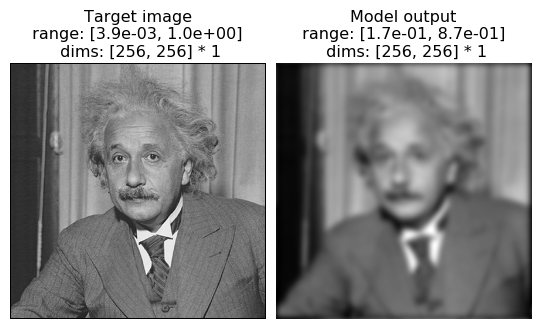

In [3]:
h = model.forward(im)
fig = po.imshow(torch.cat([im, h]), title=['Target image', 'Model output'])

Run synthesis!

In [4]:
synth = po.synthesize.SimpleMetamer(model, im)

In [5]:
# we do have a default optimizer, with a specific lr and other parameters -- 
# if you want other than the default, create one and pass it to `synthesize`
optim = torch.optim.Adam([synth.synthesized_signal], lr=.005)
s = synth.synthesize(optimizer=optim, max_iter=20)
# if we call synthesize again, resume where we left off. 
# If you don't pass an optimizer object, we re-use the old one.
s = synth.synthesize(max_iter=50)

Let's look at the loss over time!

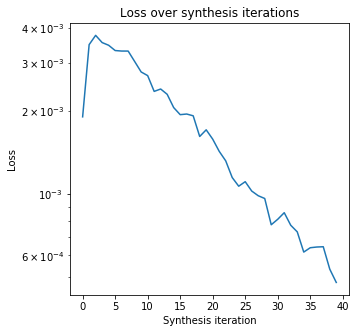

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.semilogy(synth.losses)
ax.set(title="Loss over synthesis iterations", ylabel="Loss", xlabel="Synthesis iteration");

The left column below shows the images and the right column the model outputs; top row shows the target and bottom the synthesized.

We can see that, even though the target and synthesized images look *very* different, the two model outputs look basically identical (which matches the exceedingly low loss value we see above)

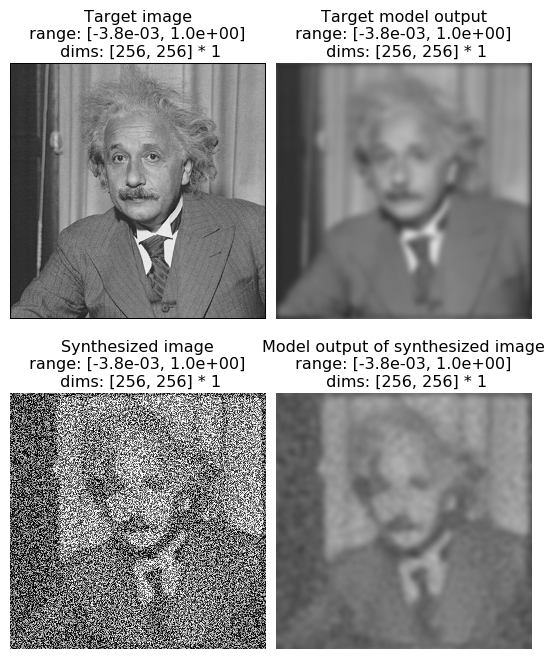

In [7]:
po.imshow(torch.cat([im, h, s, synth.model(s)]), col_wrap=2, vrange='auto1',
         title=["Target image", "Target model output", "Synthesized image", "Model output of synthesized image"]);

We also provide the methods `.to`, `.save`, and `.load`.

`.to` and `.save` work as you'd expect (`.to` works in place):

In [8]:
synth.save('test.pt')

In [9]:
print(synth.target_signal.dtype)
synth.to(torch.float16)
print(synth.target_signal.dtype)
synth.to(torch.float32)
print(synth.target_signal.dtype)

torch.float32
torch.float16
torch.float32


Because the models used in synthesis can be quite large and do not change during synthesis, we do not save them. Therefore, `.load` is an instance method: it must be called by an instance of the object, like so:

In [18]:
synth2 = po.synthesize.SimpleMetamer(model, im)
print(torch.allclose(synth2.synthesized_signal, synth.synthesized_signal, atol=1e-3))
synth2.load('test.pt')
print(torch.allclose(synth2.synthesized_signal, synth.synthesized_signal, atol=1e-3))

False
True


Because of this, we want to make sure the two versions were initialized in the same way; if you initialize `SimpleMetamer` with a different model or a different target image, it will raise an exception (in both cases, we catch this because `target_model_responses` is different, which is easier than checking whether the specific model is different):

In [23]:
synth2 = po.synthesize.SimpleMetamer(model, torch.rand_like(im))
try:
    synth2.load('test.pt')
except Exception as e:
    print(f'Exception: {e}')

Exception: Saved and initialized target_model_response are different! Initialized: tensor([[[[0.4763, 0.4760, 0.4774,  ..., 0.4927, 0.4854, 0.4795],
          [0.4884, 0.4869, 0.4870,  ..., 0.5033, 0.4974, 0.4920],
          [0.5001, 0.4975, 0.4960,  ..., 0.5139, 0.5092, 0.5042],
          ...,
          [0.4690, 0.4681, 0.4690,  ..., 0.4913, 0.4811, 0.4732],
          [0.4643, 0.4645, 0.4666,  ..., 0.4848, 0.4750, 0.4677],
          [0.4673, 0.4676, 0.4699,  ..., 0.4856, 0.4768, 0.4703]]]],
       grad_fn=<MkldnnConvolutionBackward>), Saved: tensor([[[[0.1983, 0.1921, 0.1926,  ..., 0.2636, 0.2356, 0.2129],
          [0.2051, 0.1908, 0.1849,  ..., 0.3000, 0.2623, 0.2294],
          [0.2158, 0.1948, 0.1840,  ..., 0.3360, 0.2898, 0.2482],
          ...,
          [0.2182, 0.2390, 0.2614,  ..., 0.1972, 0.1960, 0.2031],
          [0.2051, 0.2174, 0.2326,  ..., 0.2097, 0.2008, 0.1991],
          [0.1980, 0.2010, 0.2087,  ..., 0.2322, 0.2141, 0.2022]]]]), difference: tensor([[[[0.2780, 0.283

In [26]:
synth2 = po.synthesize.SimpleMetamer(po.simul.Gaussian([10, 10]), im)
try:
    synth2.load('test.pt')
except Exception as e:
    print(f'Exception: {e}')

Exception: Saved and initialized target_model_response are different! Initialized: tensor([[[[0.1816, 0.1737, 0.1731,  ..., 0.2554, 0.2241, 0.1986],
          [0.1875, 0.1697, 0.1615,  ..., 0.2976, 0.2544, 0.2162],
          [0.1975, 0.1716, 0.1573,  ..., 0.3390, 0.2854, 0.2363],
          ...,
          [0.2078, 0.2326, 0.2586,  ..., 0.1747, 0.1763, 0.1879],
          [0.1924, 0.2068, 0.2241,  ..., 0.1909, 0.1832, 0.1838],
          [0.1833, 0.1865, 0.1948,  ..., 0.2185, 0.1994, 0.1874]]]],
       grad_fn=<MkldnnConvolutionBackward>), Saved: tensor([[[[0.1983, 0.1921, 0.1926,  ..., 0.2636, 0.2356, 0.2129],
          [0.2051, 0.1908, 0.1849,  ..., 0.3000, 0.2623, 0.2294],
          [0.2158, 0.1948, 0.1840,  ..., 0.3360, 0.2898, 0.2482],
          ...,
          [0.2182, 0.2390, 0.2614,  ..., 0.1972, 0.1960, 0.2031],
          [0.2051, 0.2174, 0.2326,  ..., 0.2097, 0.2008, 0.1991],
          [0.1980, 0.2010, 0.2087,  ..., 0.2322, 0.2141, 0.2022]]]]), difference: tensor([[[[-0.0167, -0.0